#**Data engineering pipeline for "Lifestyle Factors and Their Impact on Students"**

## **Phase 1: Relational Database**

### Step 1: Setup Environment & connect with db

In [17]:
import sqlite3
conn = sqlite3.connect('student_lifestyle.db')
cursor = conn.cursor()

### Step 2: Create The NORMILIZED Tables

In [18]:
# Genders
cursor.execute("""
CREATE TABLE Genders (
    Gender_ID INTEGER PRIMARY KEY AUTOINCREMENT,
    Gender_Name TEXT UNIQUE
)
""")

# Students
cursor.execute("""
CREATE TABLE Students (
    Student_ID INTEGER PRIMARY KEY,
    Gender_ID INTEGER,
    Stress_Level TEXT,
    FOREIGN KEY (Gender_ID) REFERENCES Genders(Gender_ID)
)
""")

# Grades
cursor.execute("""
CREATE TABLE Grades (
    Grade_ID INTEGER PRIMARY KEY AUTOINCREMENT,
    Student_ID INTEGER,
    Grade_Value REAL,
    FOREIGN KEY (Student_ID) REFERENCES Students(Student_ID)
)
""")

# Daily Activities
cursor.execute("""
CREATE TABLE Daily_Activities (
    Activity_ID INTEGER PRIMARY KEY AUTOINCREMENT,
    Student_ID INTEGER,
    Study_Hours REAL,
    Extracurricular_Hours REAL,
    Sleep_Hours REAL,
    Social_Hours REAL,
    Physical_Activity_Hours REAL,
    FOREIGN KEY (Student_ID) REFERENCES Students(Student_ID)
)
""")
conn.commit()
print("Tables created")

Tables created


### insert data into tables in the relation db called student_lifestyle_dataset..csv

In [19]:
import pandas as pd

#Read content
df = pd.read_csv('/content/student_lifestyle_dataset..csv')
print(df.columns)


gender_df = df[['Gender']].drop_duplicates().reset_index(drop=True)
gender_df['Gender_ID'] = gender_df.index + 1
df = df.merge(gender_df, on='Gender')


students_df = df[['Student_ID', 'Gender_ID', 'Stress_Level']]
grades_df = df[['Student_ID', 'Grades']].rename(columns={'Grades': 'Grade_Value'})

activities_df = df[[
    'Student_ID',
    'Study_Hours_Per_Day',
    'Extracurricular_Hours_Per_Day',
    'Sleep_Hours_Per_Day',
    'Social_Hours_Per_Day',
    'Physical_Activity_Hours_Per_Day'
]].rename(columns={
    'Study_Hours_Per_Day': 'Study_Hours',
    'Extracurricular_Hours_Per_Day': 'Extracurricular_Hours',
    'Sleep_Hours_Per_Day': 'Sleep_Hours',
    'Social_Hours_Per_Day': 'Social_Hours',
    'Physical_Activity_Hours_Per_Day': 'Physical_Activity_Hours'
})



# Genders
gender_df[['Gender_ID', 'Gender']].rename(columns={'Gender': 'Gender_Name'}).to_sql('Genders', conn, if_exists='append', index=False)

# Students
students_df.to_sql('Students', conn, if_exists='append', index=False)

# Grades
grades_df.to_sql('Grades', conn, if_exists='append', index=False)

# Daily Activities
activities_df.to_sql('Daily_Activities', conn, if_exists='append', index=False)

print("Data inserted successfully")

Index(['Student_ID', 'Study_Hours_Per_Day', 'Extracurricular_Hours_Per_Day',
       'Sleep_Hours_Per_Day', 'Social_Hours_Per_Day',
       'Physical_Activity_Hours_Per_Day', 'Stress_Level', 'Gender', 'Grades'],
      dtype='object')
Data inserted successfully


### CRUD operation

In [40]:
#----------------READ

cursor.execute("SELECT * FROM Students WHERE Student_ID = 1")
print("The row 1 in student")
print(cursor.fetchall())


#----------------UPDATE
print()

cursor.execute("UPDATE Students SET Stress_Level = 'Medium' WHERE Student_ID = 1")
conn.commit()
cursor.execute("SELECT * FROM Students WHERE Student_ID = 1")
print("Update the row 1 in student")
print(cursor.fetchall())


#----------------CREATE
print()

cursor.execute("DELETE FROM Students WHERE Student_ID = 2001")
conn.commit()
cursor.execute("INSERT INTO Students (Student_ID, Gender_ID, Stress_Level) VALUES (2001, 2, 'Medium')")
conn.commit()
cursor.execute("SELECT * FROM Students WHERE Student_ID = 2001 ")
print("Create row 2001 in the last of student table")
print(cursor.fetchall())


#-----------------DELETE
print()
cursor.execute("DELETE FROM Students WHERE Student_ID = 2001")
conn.commit()
cursor.execute("SELECT * FROM Students WHERE Student_ID = 2001")
print("Delete row 2001 from the student")
print(cursor.fetchall())

The row 1 in student
[(1, 1, 'Medium')]

Update the row 1 in student
[(1, 1, 'Medium')]

Create row 2001 in the last of student table
[(2001, 2, 'Medium')]

Delete row 2001 from the student
[]


### Apply indexing and query optimization

In [21]:
import time
#--------------------------BY INDEXING


print("Query Optimization BY INDEXING")
start = time.time()
cursor.execute("SELECT * FROM Daily_Activities WHERE Study_Hours > 5")
print("Time without index:", time.time() - start)

cursor.execute("DROP INDEX IF EXISTS idx_study_hours") # IF WE REPEATE THE RUN
cursor.execute("CREATE INDEX idx_study_hours ON Daily_Activities(Study_Hours)")
conn.commit()

start = time.time()
cursor.execute("SELECT * FROM Daily_Activities WHERE Study_Hours > 5")
print("Time with index:   ", time.time() - start)


# -----------------------Using JOIN Queries

print()
print("Query Optimization Using JOIN Queries")
start = time.time()
query = """
SELECT s.Student_ID, d.Study_Hours, s.Stress_Level
FROM Students s
JOIN Daily_Activities d ON s.Student_ID = d.Student_ID
WHERE d.Study_Hours > 5
"""
df = pd.read_sql_query(query, conn)
print(df)
print("Time to process:", time.time() - start)



#----------------------Using Aggregation GROUP BY


print()
print("Query Optimization Using Aggregation GROUP BY")
start = time.time()
query = """
SELECT
    s.Student_ID,
    g.Gender_Name,
    s.Stress_Level,
    SUM(d.Study_Hours) AS Total_Study_Hours,
    AVG(gr.Grade_Value) AS Average_Grade
FROM
    Students s
JOIN
    Daily_Activities d ON s.Student_ID = d.Student_ID
JOIN
    Genders g ON s.Gender_ID = g.Gender_ID
LEFT JOIN
    Grades gr ON s.Student_ID = gr.Student_ID
GROUP BY
    s.Student_ID, g.Gender_Name, s.Stress_Level
ORDER BY
    Total_Study_Hours DESC;
"""
df = pd.read_sql_query(query, conn)
print(df)
print("Time to process:", time.time() - start)


Query Optimization BY INDEXING
Time without index: 0.0008745193481445312
Time with index:    0.0004086494445800781

Query Optimization Using JOIN Queries
      Student_ID  Study_Hours Stress_Level
0              3          5.1          Low
1             47          5.1          Low
2             59          5.1          Low
3             63          5.1         High
4            152          5.1          Low
...          ...          ...          ...
1975        1106         10.0         High
1976        1287         10.0         High
1977        1289         10.0         High
1978        1469         10.0         High
1979        1612         10.0         High

[1980 rows x 3 columns]
Time to process: 0.019385576248168945

Query Optimization Using Aggregation GROUP BY
      Student_ID Gender_Name Stress_Level  Total_Study_Hours  Average_Grade
0            101        Male         High               10.0           8.52
1            279        Male         High               10.0        

## **Phase 2: NoSQL Database**

###  Install TinyDB

In [22]:
!pip install tinydb

###  Import TinyDB

In [23]:
from tinydb import TinyDB, Query

###  Create or Connect to TinyDB Database

In [24]:
db = TinyDB('students.json')
print("Connected to TinyDB (students.json)!")

Connected to TinyDB (students.json)!


### Insert Data into TinyDB

In [25]:
# Insert the 100 student records from the previous JSON artifact
student_data = [
    {
        "student_id": 1,
        "study_hours_per_day": 6.9,
        "extracurricular_hours_per_day": 3.8,
        "sleep_hours_per_day": 8.7,
        "social_hours_per_day": 2.8,
        "physical_activity_hours_per_day": 1.8,
        "stress_level": "Moderate",
        "gender": "Male",
        "grades": 7.48
    },
    {
        "student_id": 23,
        "study_hours_per_day": 9.0,
        "extracurricular_hours_per_day": 0.7,
        "sleep_hours_per_day": 9.5,
        "social_hours_per_day": 2.6,
        "physical_activity_hours_per_day": 2.2,
        "stress_level": "High",
        "gender": "Female",
        "grades": 8.02
    },
    {
        "student_id": 45,
        "study_hours_per_day": 7.9,
        "extracurricular_hours_per_day": 2.0,
        "sleep_hours_per_day": 6.0,
        "social_hours_per_day": 4.3,
        "physical_activity_hours_per_day": 3.8,
        "stress_level": "Moderate",
        "gender": "Female",
        "grades": 7.42
    },
    {
        "student_id": 67,
        "study_hours_per_day": 8.3,
        "extracurricular_hours_per_day": 0.7,
        "sleep_hours_per_day": 5.4,
        "social_hours_per_day": 3.9,
        "physical_activity_hours_per_day": 5.7,
        "stress_level": "High",
        "gender": "Female",
        "grades": 8.15
    },
    {
        "student_id": 89,
        "study_hours_per_day": 6.1,
        "extracurricular_hours_per_day": 3.9,
        "sleep_hours_per_day": 5.1,
        "social_hours_per_day": 5.8,
        "physical_activity_hours_per_day": 3.1,
        "stress_level": "High",
        "gender": "Female",
        "grades": 7.4
    },
    {
        "student_id": 112,
        "study_hours_per_day": 5.9,
        "extracurricular_hours_per_day": 1.4,
        "sleep_hours_per_day": 9.5,
        "social_hours_per_day": 2.8,
        "physical_activity_hours_per_day": 4.4,
        "stress_level": "Low",
        "gender": "Male",
        "grades": 6.75
    },
    {
        "student_id": 134,
        "study_hours_per_day": 5.3,
        "extracurricular_hours_per_day": 4.0,
        "sleep_hours_per_day": 6.6,
        "social_hours_per_day": 4.9,
        "physical_activity_hours_per_day": 3.2,
        "stress_level": "Low",
        "gender": "Male",
        "grades": 6.8
    },
    {
        "student_id": 156,
        "study_hours_per_day": 8.0,
        "extracurricular_hours_per_day": 1.6,
        "sleep_hours_per_day": 5.3,
        "social_hours_per_day": 2.0,
        "physical_activity_hours_per_day": 7.1,
        "stress_level": "High",
        "gender": "Female",
        "grades": 8.55
    },
    {
        "student_id": 178,
        "study_hours_per_day": 8.2,
        "extracurricular_hours_per_day": 1.0,
        "sleep_hours_per_day": 5.7,
        "social_hours_per_day": 5.0,
        "physical_activity_hours_per_day": 4.1,
        "stress_level": "High",
        "gender": "Male",
        "grades": 7.22
    },
    {
        "student_id": 200,
        "study_hours_per_day": 6.6,
        "extracurricular_hours_per_day": 2.5,
        "sleep_hours_per_day": 9.4,
        "social_hours_per_day": 3.4,
        "physical_activity_hours_per_day": 2.1,
        "stress_level": "Moderate",
        "gender": "Male",
        "grades": 7.58
    },
    {
        "student_id": 223,
        "study_hours_per_day": 9.2,
        "extracurricular_hours_per_day": 2.0,
        "sleep_hours_per_day": 5.0,
        "social_hours_per_day": 1.7,
        "physical_activity_hours_per_day": 6.1,
        "stress_level": "High",
        "gender": "Female",
        "grades": 8.55
    },
    {
        "student_id": 245,
        "study_hours_per_day": 6.6,
        "extracurricular_hours_per_day": 2.1,
        "sleep_hours_per_day": 5.4,
        "social_hours_per_day": 2.1,
        "physical_activity_hours_per_day": 7.8,
        "stress_level": "High",
        "gender": "Male",
        "grades": 6.98
    },
    {
        "student_id": 267,
        "study_hours_per_day": 5.8,
        "extracurricular_hours_per_day": 0.7,
        "sleep_hours_per_day": 5.2,
        "social_hours_per_day": 4.4,
        "physical_activity_hours_per_day": 7.9,
        "stress_level": "High",
        "gender": "Female",
        "grades": 7.02
    },
    {
        "student_id": 289,
        "study_hours_per_day": 6.0,
        "extracurricular_hours_per_day": 0.0,
        "sleep_hours_per_day": 8.2,
        "social_hours_per_day": 5.4,
        "physical_activity_hours_per_day": 4.4,
        "stress_level": "Moderate",
        "gender": "Male",
        "grades": 7.3
    },
    {
        "student_id": 312,
        "study_hours_per_day": 10.0,
        "extracurricular_hours_per_day": 3.7,
        "sleep_hours_per_day": 7.7,
        "social_hours_per_day": 2.2,
        "physical_activity_hours_per_day": 0.4,
        "stress_level": "High",
        "gender": "Male",
        "grades": 8.6
    },
    {
        "student_id": 334,
        "study_hours_per_day": 5.5,
        "extracurricular_hours_per_day": 2.2,
        "sleep_hours_per_day": 7.3,
        "social_hours_per_day": 5.1,
        "physical_activity_hours_per_day": 3.9,
        "stress_level": "Low",
        "gender": "Male",
        "grades": 7.35
    },
    {
        "student_id": 356,
        "study_hours_per_day": 7.5,
        "extracurricular_hours_per_day": 3.4,
        "sleep_hours_per_day": 8.7,
        "social_hours_per_day": 2.4,
        "physical_activity_hours_per_day": 2.0,
        "stress_level": "Moderate",
        "gender": "Male",
        "grades": 8.1
    },
    {
        "student_id": 378,
        "study_hours_per_day": 5.7,
        "extracurricular_hours_per_day": 0.3,
        "sleep_hours_per_day": 8.6,
        "social_hours_per_day": 3.0,
        "physical_activity_hours_per_day": 6.4,
        "stress_level": "Low",
        "gender": "Male",
        "grades": 5.7
    },
    {
        "student_id": 400,
        "study_hours_per_day": 7.6,
        "extracurricular_hours_per_day": 3.7,
        "sleep_hours_per_day": 5.8,
        "social_hours_per_day": 4.5,
        "physical_activity_hours_per_day": 2.4,
        "stress_level": "High",
        "gender": "Male",
        "grades": 7.92
    },
    {
        "student_id": 423,
        "study_hours_per_day": 9.0,
        "extracurricular_hours_per_day": 1.7,
        "sleep_hours_per_day": 9.8,
        "social_hours_per_day": 0.9,
        "physical_activity_hours_per_day": 2.6,
        "stress_level": "High",
        "gender": "Female",
        "grades": 8.45
    },
    {
        "student_id": 445,
        "study_hours_per_day": 6.8,
        "extracurricular_hours_per_day": 2.9,
        "sleep_hours_per_day": 6.0,
        "social_hours_per_day": 2.8,
        "physical_activity_hours_per_day": 5.5,
        "stress_level": "Moderate",
        "gender": "Female",
        "grades": 7.65
    },
    {
        "student_id": 467,
        "study_hours_per_day": 8.4,
        "extracurricular_hours_per_day": 1.8,
        "sleep_hours_per_day": 7.0,
        "social_hours_per_day": 4.0,
        "physical_activity_hours_per_day": 3.8,
        "stress_level": "High",
        "gender": "Male",
        "grades": 8.3
    },
    {
        "student_id": 489,
        "study_hours_per_day": 7.2,
        "extracurricular_hours_per_day": 0.6,
        "sleep_hours_per_day": 8.1,
        "social_hours_per_day": 3.4,
        "physical_activity_hours_per_day": 4.7,
        "stress_level": "Moderate",
        "gender": "Male",
        "grades": 7.9
    },
    {
        "student_id": 512,
        "study_hours_per_day": 6.2,
        "extracurricular_hours_per_day": 2.4,
        "sleep_hours_per_day": 9.1,
        "social_hours_per_day": 4.3,
        "physical_activity_hours_per_day": 2.0,
        "stress_level": "Moderate",
        "gender": "Female",
        "grades": 7.25
    },
    {
        "student_id": 534,
        "study_hours_per_day": 8.9,
        "extracurricular_hours_per_day": 3.2,
        "sleep_hours_per_day": 6.4,
        "social_hours_per_day": 2.1,
        "physical_activity_hours_per_day": 3.4,
        "stress_level": "High",
        "gender": "Female",
        "grades": 8.7
    },
    {
        "student_id": 556,
        "study_hours_per_day": 7.3,
        "extracurricular_hours_per_day": 1.8,
        "sleep_hours_per_day": 7.9,
        "social_hours_per_day": 4.6,
        "physical_activity_hours_per_day": 3.0,
        "stress_level": "Moderate",
        "gender": "Male",
        "grades": 7.8
    },
    {
        "student_id": 578,
        "study_hours_per_day": 5.9,
        "extracurricular_hours_per_day": 0.4,
        "sleep_hours_per_day": 8.7,
        "social_hours_per_day": 5.1,
        "physical_activity_hours_per_day": 4.9,
        "stress_level": "Low",
        "gender": "Female",
        "grades": 6.92
    },
    {
        "student_id": 600,
        "study_hours_per_day": 8.1,
        "extracurricular_hours_per_day": 2.6,
        "sleep_hours_per_day": 6.8,
        "social_hours_per_day": 3.0,
        "physical_activity_hours_per_day": 4.5,
        "stress_level": "High",
        "gender": "Male",
        "grades": 8.25
    },
    {
        "student_id": 623,
        "study_hours_per_day": 6.7,
        "extracurricular_hours_per_day": 3.0,
        "sleep_hours_per_day": 5.6,
        "social_hours_per_day": 4.2,
        "physical_activity_hours_per_day": 4.1,
        "stress_level": "High",
        "gender": "Female",
        "grades": 7.48
    },
    {
        "student_id": 645,
        "study_hours_per_day": 9.4,
        "extracurricular_hours_per_day": 1.9,
        "sleep_hours_per_day": 7.2,
        "social_hours_per_day": 2.8,
        "physical_activity_hours_per_day": 3.7,
        "stress_level": "High",
        "gender": "Male",
        "grades": 8.9
    },
    {
        "student_id": 667,
        "study_hours_per_day": 7.8,
        "extracurricular_hours_per_day": 2.4,
        "sleep_hours_per_day": 8.3,
        "social_hours_per_day": 1.6,
        "physical_activity_hours_per_day": 5.9,
        "stress_level": "Moderate",
        "gender": "Male",
        "grades": 7.72
    },
    {
        "student_id": 689,
        "study_hours_per_day": 6.5,
        "extracurricular_hours_per_day": 0.8,
        "sleep_hours_per_day": 9.0,
        "social_hours_per_day": 4.7,
        "physical_activity_hours_per_day": 3.0,
        "stress_level": "Moderate",
        "gender": "Female",
        "grades": 7.15
    },
    {
        "student_id": 712,
        "study_hours_per_day": 8.6,
        "extracurricular_hours_per_day": 3.5,
        "sleep_hours_per_day": 6.2,
        "social_hours_per_day": 2.0,
        "physical_activity_hours_per_day": 4.3,
        "stress_level": "High",
        "gender": "Male",
        "grades": 8.45
    },
    {
        "student_id": 734,
        "study_hours_per_day": 7.0,
        "extracurricular_hours_per_day": 1.4,
        "sleep_hours_per_day": 8.6,
        "social_hours_per_day": 3.9,
        "physical_activity_hours_per_day": 3.1,
        "stress_level": "Moderate",
        "gender": "Female",
        "grades": 7.8
    },
    {
        "student_id": 756,
        "study_hours_per_day": 9.2,
        "extracurricular_hours_per_day": 2.7,
        "sleep_hours_per_day": 7.4,
        "social_hours_per_day": 1.8,
        "physical_activity_hours_per_day": 4.9,
        "stress_level": "High",
        "gender": "Female",
        "grades": 8.65
    },
    {
        "student_id": 778,
        "study_hours_per_day": 6.3,
        "extracurricular_hours_per_day": 3.2,
        "sleep_hours_per_day": 5.9,
        "social_hours_per_day": 4.6,
        "physical_activity_hours_per_day": 4.0,
        "stress_level": "High",
        "gender": "Male",
        "grades": 7.35
    },
    {
        "student_id": 800,
        "study_hours_per_day": 8.7,
        "extracurricular_hours_per_day": 1.6,
        "sleep_hours_per_day": 9.2,
        "social_hours_per_day": 2.4,
        "physical_activity_hours_per_day": 3.1,
        "stress_level": "High",
        "gender": "Female",
        "grades": 8.9
    },
    {
        "student_id": 823,
        "study_hours_per_day": 7.4,
        "extracurricular_hours_per_day": 2.8,
        "sleep_hours_per_day": 6.7,
        "social_hours_per_day": 3.5,
        "physical_activity_hours_per_day": 4.6,
        "stress_level": "Moderate",
        "gender": "Male",
        "grades": 7.62
    },
    {
        "student_id": 845,
        "study_hours_per_day": 6.9,
        "extracurricular_hours_per_day": 0.9,
        "sleep_hours_per_day": 8.4,
        "social_hours_per_day": 4.2,
        "physical_activity_hours_per_day": 3.6,
        "stress_level": "Moderate",
        "gender": "Female",
        "grades": 7.25
    },
    {
        "student_id": 867,
        "study_hours_per_day": 8.1,
        "extracurricular_hours_per_day": 2.3,
        "sleep_hours_per_day": 7.0,
        "social_hours_per_day": 3.8,
        "physical_activity_hours_per_day": 3.8,
        "stress_level": "High",
        "gender": "Male",
        "grades": 8.15
    },
    {
        "student_id": 889,
        "study_hours_per_day": 7.6,
        "extracurricular_hours_per_day": 1.9,
        "sleep_hours_per_day": 8.9,
        "social_hours_per_day": 2.6,
        "physical_activity_hours_per_day": 4.0,
        "stress_level": "Moderate",
        "gender": "Female",
        "grades": 7.8
    },
    {
        "student_id": 912,
        "study_hours_per_day": 9.3,
        "extracurricular_hours_per_day": 3.0,
        "sleep_hours_per_day": 6.5,
        "social_hours_per_day": 2.0,
        "physical_activity_hours_per_day": 4.2,
        "stress_level": "High",
        "gender": "Male",
        "grades": 8.45
    },
    {
        "student_id": 934,
        "study_hours_per_day": 6.7,
        "extracurricular_hours_per_day": 2.4,
        "sleep_hours_per_day": 7.8,
        "social_hours_per_day": 4.0,
        "physical_activity_hours_per_day": 3.1,
        "stress_level": "Moderate",
        "gender": "Female",
        "grades": 7.62
    },
    {
        "student_id": 956,
        "study_hours_per_day": 8.4,
        "extracurricular_hours_per_day": 1.7,
        "sleep_hours_per_day": 9.0,
        "social_hours_per_day": 2.8,
        "physical_activity_hours_per_day": 3.9,
        "stress_level": "High",
        "gender": "Male",
        "grades": 8.3
    },
    {
        "student_id": 978,
        "study_hours_per_day": 7.2,
        "extracurricular_hours_per_day": 3.1,
        "sleep_hours_per_day": 6.9,
        "social_hours_per_day": 3.5,
        "physical_activity_hours_per_day": 4.5,
        "stress_level": "Moderate",
        "gender": "Female",
        "grades": 7.9
    },
    {
        "student_id": 1000,
        "study_hours_per_day": 9.0,
        "extracurricular_hours_per_day": 1.7,
        "sleep_hours_per_day": 7.3,
        "social_hours_per_day": 3.1,
        "physical_activity_hours_per_day": 2.9,
        "stress_level": "High",
        "gender": "Male",
        "grades": 8.95
    },
    {
        "student_id": 1023,
        "study_hours_per_day": 6.5,
        "extracurricular_hours_per_day": 2.0,
        "sleep_hours_per_day": 8.6,
        "social_hours_per_day": 4.3,
        "physical_activity_hours_per_day": 3.6,
        "stress_level": "Moderate",
        "gender": "Female",
        "grades": 7.45
    },
    {
        "student_id": 1045,
        "study_hours_per_day": 8.7,
        "extracurricular_hours_per_day": 2.9,
        "sleep_hours_per_day": 7.2,
        "social_hours_per_day": 2.4,
        "physical_activity_hours_per_day": 4.8,
        "stress_level": "High",
        "gender": "Male",
        "grades": 8.6
    },
    {
        "student_id": 1067,
        "study_hours_per_day": 7.9,
        "extracurricular_hours_per_day": 1.5,
        "sleep_hours_per_day": 8.4,
        "social_hours_per_day": 3.7,
        "physical_activity_hours_per_day": 3.4,
        "stress_level": "Moderate",
        "gender": "Male",
        "grades": 7.72
    },
    {
        "student_id": 1089,
        "study_hours_per_day": 6.3,
        "extracurricular_hours_per_day": 2.7,
        "sleep_hours_per_day": 7.9,
        "social_hours_per_day": 4.1,
        "physical_activity_hours_per_day": 3.0,
        "stress_level": "Moderate",
        "gender": "Female",
        "grades": 7.25
    },
    {
        "student_id": 1112,
        "study_hours_per_day": 8.5,
        "extracurricular_hours_per_day": 3.2,
        "sleep_hours_per_day": 6.7,
        "social_hours_per_day": 2.0,
        "physical_activity_hours_per_day": 4.1,
        "stress_level": "High",
        "gender": "Male",
        "grades": 8.9
    },
    {
        "student_id": 1134,
        "study_hours_per_day": 7.0,
        "extracurricular_hours_per_day": 1.9,
        "sleep_hours_per_day": 8.3,
        "social_hours_per_day": 3.8,
        "physical_activity_hours_per_day": 3.0,
        "stress_level": "Moderate",
        "gender": "Female",
        "grades": 7.62
    },
    {
        "student_id": 1156,
        "study_hours_per_day": 9.2,
        "extracurricular_hours_per_day": 2.5,
        "sleep_hours_per_day": 7.0,
        "social_hours_per_day": 2.6,
        "physical_activity_hours_per_day": 4.9,
        "stress_level": "High",
        "gender": "Male",
        "grades": 8.45
    },
    {
        "student_id": 1178,
        "study_hours_per_day": 6.8,
        "extracurricular_hours_per_day": 3.0,
        "sleep_hours_per_day": 8.6,
        "social_hours_per_day": 3.4,
        "physical_activity_hours_per_day": 2.6,
        "stress_level": "Moderate",
        "gender": "Female",
        "grades": 7.9
    },
    {
        "student_id": 1200,
        "study_hours_per_day": 8.7,
        "extracurricular_hours_per_day": 1.8,
        "sleep_hours_per_day": 7.4,
        "social_hours_per_day": 2.8,
        "physical_activity_hours_per_day": 4.5,
        "stress_level": "High",
        "gender": "Male",
        "grades": 8.3
    },
    {
        "student_id": 1223,
        "study_hours_per_day": 7.4,
        "extracurricular_hours_per_day": 2.6,
        "sleep_hours_per_day": 8.0,
        "social_hours_per_day": 3.2,
        "physical_activity_hours_per_day": 3.8,
        "stress_level": "Moderate",
        "gender": "Female",
        "grades": 7.65
    },
    {
        "student_id": 1245,
        "study_hours_per_day": 6.9,
        "extracurricular_hours_per_day": 2.3,
        "sleep_hours_per_day": 7.6,
        "social_hours_per_day": 4.0,
        "physical_activity_hours_per_day": 3.1,
        "stress_level": "Moderate",
        "gender": "Male",
        "grades": 7.8
    },
    {
        "student_id": 1267,
        "study_hours_per_day": 8.4,
        "extracurricular_hours_per_day": 1.9,
        "sleep_hours_per_day": 9.1,
        "social_hours_per_day": 2.7,
        "physical_activity_hours_per_day": 4.3,
        "stress_level": "High",
        "gender": "Female",
        "grades": 8.25
    },
    {
        "student_id": 1289,
        "study_hours_per_day": 7.6,
        "extracurricular_hours_per_day": 3.0,
        "sleep_hours_per_day": 6.8,
        "social_hours_per_day": 3.5,
        "physical_activity_hours_per_day": 4.7,
        "stress_level": "Moderate",
        "gender": "Male",
        "grades": 7.9
    },
    {
        "student_id": 1312,
        "study_hours_per_day": 9.0,
        "extracurricular_hours_per_day": 2.4,
        "sleep_hours_per_day": 7.2,
        "social_hours_per_day": 2.9,
        "physical_activity_hours_per_day": 4.5,
        "stress_level": "High",
        "gender": "Female",
        "grades": 8.6
    },
    {
        "student_id": 1334,
        "study_hours_per_day": 6.5,
        "extracurricular_hours_per_day": 1.8,
        "sleep_hours_per_day": 8.7,
        "social_hours_per_day": 4.1,
        "physical_activity_hours_per_day": 3.0,
        "stress_level": "Moderate",
        "gender": "Male",
        "grades": 7.45
    },
    {
        "student_id": 1356,
        "study_hours_per_day": 8.7,
        "extracurricular_hours_per_day": 2.7,
        "sleep_hours_per_day": 6.9,
        "social_hours_per_day": 2.3,
        "physical_activity_hours_per_day": 4.8,
        "stress_level": "High",
        "gender": "Female",
        "grades": 8.9
    },
    {
        "student_id": 1378,
        "study_hours_per_day": 7.2,
        "extracurricular_hours_per_day": 3.1,
        "sleep_hours_per_day": 8.0,
        "social_hours_per_day": 3.7,
        "physical_activity_hours_per_day": 3.2,
        "stress_level": "Moderate",
        "gender": "Male",
        "grades": 7.62
    },
    {
        "student_id": 1400,
        "study_hours_per_day": 9.1,
        "extracurricular_hours_per_day": 2.0,
        "sleep_hours_per_day": 7.4,
        "social_hours_per_day": 2.5,
        "physical_activity_hours_per_day": 4.9,
        "stress_level": "High",
        "gender": "Female",
        "grades": 8.45
    },
    {
        "student_id": 1423,
        "study_hours_per_day": 6.8,
        "extracurricular_hours_per_day": 2.9,
        "sleep_hours_per_day": 8.6,
        "social_hours_per_day": 3.3,
        "physical_activity_hours_per_day": 3.0,
        "stress_level": "Moderate",
        "gender": "Male",
        "grades": 7.8
    },
    {
        "student_id": 1445,
        "study_hours_per_day": 8.4,
        "extracurricular_hours_per_day": 1.6,
        "sleep_hours_per_day": 7.0,
        "social_hours_per_day": 4.0,
        "physical_activity_hours_per_day": 3.8,
        "stress_level": "High",
        "gender": "Female",
        "grades": 8.3
    },
    {
        "student_id": 1467,
        "study_hours_per_day": 7.0,
        "extracurricular_hours_per_day": 3.2,
        "sleep_hours_per_day": 8.9,
        "social_hours_per_day": 2.7,
        "physical_activity_hours_per_day": 4.1,
        "stress_level": "Moderate",
        "gender": "Male",
        "grades": 7.65
    },
    {
        "student_id": 1489,
        "study_hours_per_day": 9.2,
        "extracurricular_hours_per_day": 2.5,
        "sleep_hours_per_day": 6.8,
        "social_hours_per_day": 3.1,
        "physical_activity_hours_per_day": 4.7,
        "stress_level": "High",
        "gender": "Female",
        "grades": 8.9
    },
    {
        "student_id": 1512,
        "study_hours_per_day": 6.9,
        "extracurricular_hours_per_day": 1.9,
        "sleep_hours_per_day": 8.4,
        "social_hours_per_day": 3.8,
        "physical_activity_hours_per_day": 3.2,
        "stress_level": "Moderate",
        "gender": "Male",
        "grades": 7.45
    },
    {
        "student_id": 1534,
        "study_hours_per_day": 8.7,
        "extracurricular_hours_per_day": 3.0,
        "sleep_hours_per_day": 7.2,
        "social_hours_per_day": 2.6,
        "physical_activity_hours_per_day": 4.5,
        "stress_level": "High",
        "gender": "Female",
        "grades": 8.6
    },
    {
        "student_id": 1556,
        "study_hours_per_day": 7.4,
        "extracurricular_hours_per_day": 2.4,
        "sleep_hours_per_day": 8.0,
        "social_hours_per_day": 3.9,
        "physical_activity_hours_per_day": 3.0,
        "stress_level": "Moderate",
        "gender": "Male",
        "grades": 7.8
    },
    {
        "student_id": 1578,
        "study_hours_per_day": 6.8,
        "extracurricular_hours_per_day": 1.8,
        "sleep_hours_per_day": 9.1,
        "social_hours_per_day": 4.2,
        "physical_activity_hours_per_day": 3.6,
        "stress_level": "Moderate",
        "gender": "Female",
        "grades": 7.25
    },
    {
        "student_id": 1600,
        "study_hours_per_day": 9.0,
        "extracurricular_hours_per_day": 2.7,
        "sleep_hours_per_day": 6.9,
        "social_hours_per_day": 2.8,
        "physical_activity_hours_per_day": 4.6,
        "stress_level": "High",
        "gender": "Male",
        "grades": 8.9
    },
    {
        "student_id": 1623,
        "study_hours_per_day": 7.6,
        "extracurricular_hours_per_day": 3.1,
        "sleep_hours_per_day": 8.4,
        "social_hours_per_day": 3.4,
        "physical_activity_hours_per_day": 3.1,
        "stress_level": "Moderate",
        "gender": "Female",
        "grades": 7.62
    },
    {
        "student_id": 1645,
        "study_hours_per_day": 8.0,
        "extracurricular_hours_per_day": 2.4,
        "sleep_hours_per_day": 9.1,
        "social_hours_per_day": 1.9,
        "physical_activity_hours_per_day": 2.6,
        "stress_level": "Moderate",
        "gender": "Male",
        "grades": 7.52
    },
    {
        "student_id": 1667,
        "study_hours_per_day": 6.2,
        "extracurricular_hours_per_day": 1.3,
        "sleep_hours_per_day": 6.0,
        "social_hours_per_day": 3.0,
        "physical_activity_hours_per_day": 7.5,
        "stress_level": "Moderate",
        "gender": "Female",
        "grades": 7.8
    },
    {
        "student_id": 1689,
        "study_hours_per_day": 9.6,
        "extracurricular_hours_per_day": 0.5,
        "sleep_hours_per_day": 5.5,
        "social_hours_per_day": 2.0,
        "physical_activity_hours_per_day": 6.4,
        "stress_level": "High",
        "gender": "Male",
        "grades": 7.98
    },
    {
        "student_id": 1712,
        "study_hours_per_day": 6.7,
        "extracurricular_hours_per_day": 1.9,
        "sleep_hours_per_day": 6.5,
        "social_hours_per_day": 3.1,
        "physical_activity_hours_per_day": 5.8,
        "stress_level": "Moderate",
        "gender": "Male",
        "grades": 7.18
    },
    {
        "student_id": 1734,
        "study_hours_per_day": 5.7,
        "extracurricular_hours_per_day": 1.2,
        "sleep_hours_per_day": 5.7,
        "social_hours_per_day": 4.9,
        "physical_activity_hours_per_day": 6.5,
        "stress_level": "High",
        "gender": "Female",
        "grades": 6.65
    },
    {
        "student_id": 1756,
        "study_hours_per_day": 7.7,
        "extracurricular_hours_per_day": 1.1,
        "sleep_hours_per_day": 9.5,
        "social_hours_per_day": 5.3,
        "physical_activity_hours_per_day": 0.4,
        "stress_level": "Moderate",
        "gender": "Female",
        "grades": 7.48
    },
    {
        "student_id": 1778,
        "study_hours_per_day": 7.2,
        "extracurricular_hours_per_day": 2.9,
        "sleep_hours_per_day": 6.9,
        "social_hours_per_day": 1.3,
        "physical_activity_hours_per_day": 5.7,
        "stress_level": "Moderate",
        "gender": "Male",
        "grades": 8.07
    },
    {
        "student_id": 1800,
        "study_hours_per_day": 7.4,
        "extracurricular_hours_per_day": 0.2,
        "sleep_hours_per_day": 9.9,
        "social_hours_per_day": 4.3,
        "physical_activity_hours_per_day": 2.2,
        "stress_level": "Moderate",
        "gender": "Male",
        "grades": 7.1
    },
    {
        "student_id": 1823,
        "study_hours_per_day": 8.5,
        "extracurricular_hours_per_day": 2.3,
        "sleep_hours_per_day": 9.2,
        "social_hours_per_day": 0.3,
        "physical_activity_hours_per_day": 3.7,
        "stress_level": "High",
        "gender": "Female",
        "grades": 8.35
    },
    {
        "student_id": 1845,
        "study_hours_per_day": 7.0,
        "extracurricular_hours_per_day": 2.3,
        "sleep_hours_per_day": 9.7,
        "social_hours_per_day": 0.3,
        "physical_activity_hours_per_day": 4.7,
        "stress_level": "Moderate",
        "gender": "Female",
        "grades": 6.6
    },
    {
        "student_id": 1867,
        "study_hours_per_day": 6.3,
        "extracurricular_hours_per_day": 2.1,
        "sleep_hours_per_day": 5.1,
        "social_hours_per_day": 1.6,
        "physical_activity_hours_per_day": 8.9,
        "stress_level": "High",
        "gender": "Female",
        "grades": 8.72
    },
    {
        "student_id": 1889,
        "study_hours_per_day": 5.7,
        "extracurricular_hours_per_day": 2.2,
        "sleep_hours_per_day": 9.6,
        "social_hours_per_day": 2.3,
        "physical_activity_hours_per_day": 4.2,
        "stress_level": "Low",
        "gender": "Male",
        "grades": 7.45
    },
    {
        "student_id": 1912,
        "study_hours_per_day": 5.0,
        "extracurricular_hours_per_day": 3.9,
        "sleep_hours_per_day": 9.4,
        "social_hours_per_day": 5.1,
        "physical_activity_hours_per_day": 0.6,
        "stress_level": "Low",
        "gender": "Female",
        "grades": 7.45
    },
    {
        "student_id": 1934,
        "study_hours_per_day": 9.3,
        "extracurricular_hours_per_day": 1.6,
        "sleep_hours_per_day": 9.4,
        "social_hours_per_day": 0.9,
        "physical_activity_hours_per_day": 2.8,
        "stress_level": "High",
        "gender": "Male",
        "grades": 9.22
    },
    {
        "student_id": 1956,
        "study_hours_per_day": 8.3,
        "extracurricular_hours_per_day": 3.8,
        "sleep_hours_per_day": 9.1,
        "social_hours_per_day": 0.1,
        "physical_activity_hours_per_day": 2.7,
        "stress_level": "High",
        "gender": "Male",
        "grades": 8.7
    },
    {
        "student_id": 1978,
        "study_hours_per_day": 9.1,
        "extracurricular_hours_per_day": 3.1,
        "sleep_hours_per_day": 8.9,
        "social_hours_per_day": 2.1,
        "physical_activity_hours_per_day": 0.8,
        "stress_level": "High",
        "gender": "Male",
        "grades": 7.75
    },
    {
        "student_id": 2000,
        "study_hours_per_day": 9.0,
        "extracurricular_hours_per_day": 1.7,
        "sleep_hours_per_day": 7.3,
        "social_hours_per_day": 3.1,
        "physical_activity_hours_per_day": 2.9,
        "stress_level": "High",
        "gender": "Male",
        "grades": 8.95
    }
]

db.insert_multiple(student_data)
print("Inserted 100 student records!")


Inserted 100 student records!


### Total number of students

In [26]:
print("\nTotal number of students:", len(db))


Total number of students: 273


### Students with GPA >= 7 for scholarships

In [27]:
Student = Query()
print("\nStudents eligible for scholarships (GPA >= 7):")
scholarship_students = db.search(Student.grades >= 7)
for student in scholarship_students:
    print(f"Student ID: {student['student_id']}, GPA: {student['grades']}")


Students eligible for scholarships (GPA >= 7):
Student ID: 1, GPA: 7.48
Student ID: 23, GPA: 8.02
Student ID: 45, GPA: 7.42
Student ID: 67, GPA: 8.15
Student ID: 89, GPA: 7.4
Student ID: 156, GPA: 8.55
Student ID: 178, GPA: 7.22
Student ID: 200, GPA: 7.58
Student ID: 223, GPA: 8.55
Student ID: 267, GPA: 7.02
Student ID: 289, GPA: 7.3
Student ID: 312, GPA: 8.6
Student ID: 334, GPA: 7.35
Student ID: 356, GPA: 8.1
Student ID: 400, GPA: 7.92
Student ID: 423, GPA: 8.45
Student ID: 445, GPA: 7.65
Student ID: 467, GPA: 8.3
Student ID: 489, GPA: 7.9
Student ID: 512, GPA: 7.25
Student ID: 534, GPA: 8.7
Student ID: 556, GPA: 7.8
Student ID: 600, GPA: 8.25
Student ID: 623, GPA: 7.48
Student ID: 645, GPA: 8.9
Student ID: 667, GPA: 7.72
Student ID: 689, GPA: 7.15
Student ID: 712, GPA: 8.45
Student ID: 734, GPA: 7.8
Student ID: 756, GPA: 8.65
Student ID: 778, GPA: 7.35
Student ID: 800, GPA: 8.9
Student ID: 823, GPA: 7.62
Student ID: 845, GPA: 7.25
Student ID: 867, GPA: 8.15
Student ID: 889, GPA: 7.

### Students with Moderate or High stress level for counseling

In [28]:
print("\nStudents recommended for counseling (Moderate or High stress):")
counseling_students = db.search(Student.stress_level.one_of(['Moderate', 'High']))
for student in counseling_students:
    print(f"Student ID: {student['student_id']}, Stress Level: {student['stress_level']}")


Students recommended for counseling (Moderate or High stress):
Student ID: 1, Stress Level: Moderate
Student ID: 23, Stress Level: High
Student ID: 45, Stress Level: Moderate
Student ID: 67, Stress Level: High
Student ID: 89, Stress Level: High
Student ID: 156, Stress Level: High
Student ID: 178, Stress Level: High
Student ID: 200, Stress Level: Moderate
Student ID: 223, Stress Level: High
Student ID: 245, Stress Level: High
Student ID: 267, Stress Level: High
Student ID: 289, Stress Level: Moderate
Student ID: 312, Stress Level: High
Student ID: 356, Stress Level: Moderate
Student ID: 400, Stress Level: High
Student ID: 423, Stress Level: High
Student ID: 445, Stress Level: Moderate
Student ID: 467, Stress Level: High
Student ID: 489, Stress Level: Moderate
Student ID: 512, Stress Level: Moderate
Student ID: 534, Stress Level: High
Student ID: 556, Stress Level: Moderate
Student ID: 600, Stress Level: High
Student ID: 623, Stress Level: High
Student ID: 645, Stress Level: High
Studen

### Students with high physical activity (>= 5 hours/day) for sports scholarships

In [29]:

print("\nStudents eligible for sports scholarships (Physical Activity >= 5 hours/day):")
sports_students = db.search(Student.physical_activity_hours_per_day >= 5)
for student in sports_students:
    print(f"Student ID: {student['student_id']}, Physical Activity: {student['physical_activity_hours_per_day']} hours")



Students eligible for sports scholarships (Physical Activity >= 5 hours/day):
Student ID: 67, Physical Activity: 5.7 hours
Student ID: 156, Physical Activity: 7.1 hours
Student ID: 223, Physical Activity: 6.1 hours
Student ID: 245, Physical Activity: 7.8 hours
Student ID: 267, Physical Activity: 7.9 hours
Student ID: 378, Physical Activity: 6.4 hours
Student ID: 445, Physical Activity: 5.5 hours
Student ID: 667, Physical Activity: 5.9 hours
Student ID: 1667, Physical Activity: 7.5 hours
Student ID: 1689, Physical Activity: 6.4 hours
Student ID: 1712, Physical Activity: 5.8 hours
Student ID: 1734, Physical Activity: 6.5 hours
Student ID: 1778, Physical Activity: 5.7 hours
Student ID: 1867, Physical Activity: 8.9 hours
Student ID: 67, Physical Activity: 5.7 hours
Student ID: 156, Physical Activity: 7.1 hours
Student ID: 223, Physical Activity: 6.1 hours
Student ID: 245, Physical Activity: 7.8 hours
Student ID: 267, Physical Activity: 7.9 hours
Student ID: 378, Physical Activity: 6.4 hou

### Delete students with GPA <= 3

In [30]:

db.remove(Student.grades <= 3)
print("\nDeleted students with GPA <= 3!")


Deleted students with GPA <= 3!


### Step 10: Count Documents

In [31]:
print("\nTotal number of students:", len(db))



Total number of students: 273


## **Phase 3: Stream Processing**

In [32]:
!pip install -q pyspark

In [34]:
#Start SparkSession
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("StudentsLifeStyle").getOrCreate()

df = spark.read.csv("/content/student_lifestyle_dataset..csv", header=True )

# Create DataFrame

df.show()

+----------+-------------------+-----------------------------+-------------------+--------------------+-------------------------------+------------+------+------+
|Student_ID|Study_Hours_Per_Day|Extracurricular_Hours_Per_Day|Sleep_Hours_Per_Day|Social_Hours_Per_Day|Physical_Activity_Hours_Per_Day|Stress_Level|Gender|Grades|
+----------+-------------------+-----------------------------+-------------------+--------------------+-------------------------------+------------+------+------+
|         1|                6.9|                          3.8|                8.7|                 2.8|                            1.8|    Moderate|  Male|  7.48|
|         2|                5.3|                          3.5|                8.0|                 4.2|                            3.0|         Low|Female|  6.88|
|         3|                5.1|                          3.9|                9.2|                 1.2|                            4.6|         Low|  Male|  6.68|
|         4|          

### 🔍 Filter Students with Grade ≥ 9.75


In [35]:
# Filter students with grades above 9.75/10
filtered_df = df.filter(df["grades"] >= 9.75)
filtered_df.show()

+----------+-------------------+-----------------------------+-------------------+--------------------+-------------------------------+------------+------+------+
|Student_ID|Study_Hours_Per_Day|Extracurricular_Hours_Per_Day|Sleep_Hours_Per_Day|Social_Hours_Per_Day|Physical_Activity_Hours_Per_Day|Stress_Level|Gender|Grades|
+----------+-------------------+-----------------------------+-------------------+--------------------+-------------------------------+------------+------+------+
|        52|                9.0|                          2.6|                8.5|                 3.1|                            0.8|        High|Female|  10.0|
|       871|                9.7|                          0.1|                5.8|                 5.3|                            3.1|        High|  Male|   9.8|
|      1230|                9.8|                          1.9|                5.3|                 3.3|                            3.7|        High|  Male|  9.82|
|      1455|          

### selecting specific columns

In [36]:
selected_df = df.select(df["student_id"],df["grades"])
selected_df.show()


+----------+------+
|student_id|grades|
+----------+------+
|         1|  7.48|
|         2|  6.88|
|         3|  6.68|
|         4|   7.2|
|         5|  8.78|
|         6|  7.12|
|         7|   7.7|
|         8|   8.0|
|         9|  7.05|
|        10|   6.9|
|        11|  8.57|
|        12|  7.42|
|        13|  7.05|
|        14|  7.18|
|        15|   8.5|
|        16|   8.0|
|        17|   8.4|
|        18|  7.98|
|        19|   7.9|
|        20|  7.32|
+----------+------+
only showing top 20 rows



###sort students by grades

In [37]:
sorted_df = df.orderBy(df["grades"].desc())
sorted_df.show()

+----------+-------------------+-----------------------------+-------------------+--------------------+-------------------------------+------------+------+------+
|Student_ID|Study_Hours_Per_Day|Extracurricular_Hours_Per_Day|Sleep_Hours_Per_Day|Social_Hours_Per_Day|Physical_Activity_Hours_Per_Day|Stress_Level|Gender|Grades|
+----------+-------------------+-----------------------------+-------------------+--------------------+-------------------------------+------------+------+------+
|      1230|                9.8|                          1.9|                5.3|                 3.3|                            3.7|        High|  Male|  9.82|
|       871|                9.7|                          0.1|                5.8|                 5.3|                            3.1|        High|  Male|   9.8|
|      1455|                9.4|                          1.8|                9.5|                 2.5|                            0.8|        High|  Male|  9.78|
|      1589|          

### save files

In [38]:
output_path = "/content/output_students"
output_path2 = "/content/output_students2"
output_path3 = "/content/output_students3"

filtered_df.write.mode("overwrite").csv(f"{output_path}")
selected_df.write.mode("overwrite").csv(f"{output_path2}")
sorted_df.write.mode("overwrite").csv(f"{output_path3}")


import os
print("Files saved to:", os.listdir(output_path))

Files saved to: ['part-00000-d3d3a282-6377-41fe-a4b7-4b6513d22a21-c000.csv', '_SUCCESS', '.part-00000-d3d3a282-6377-41fe-a4b7-4b6513d22a21-c000.csv.crc', '._SUCCESS.crc']


## **Phase 4: Integration**

###Convert CSV file into a full dashboard that uses SQLite (relational database), TinyDB (NoSQL), and JSON streaming files **using Anaconda** localy.

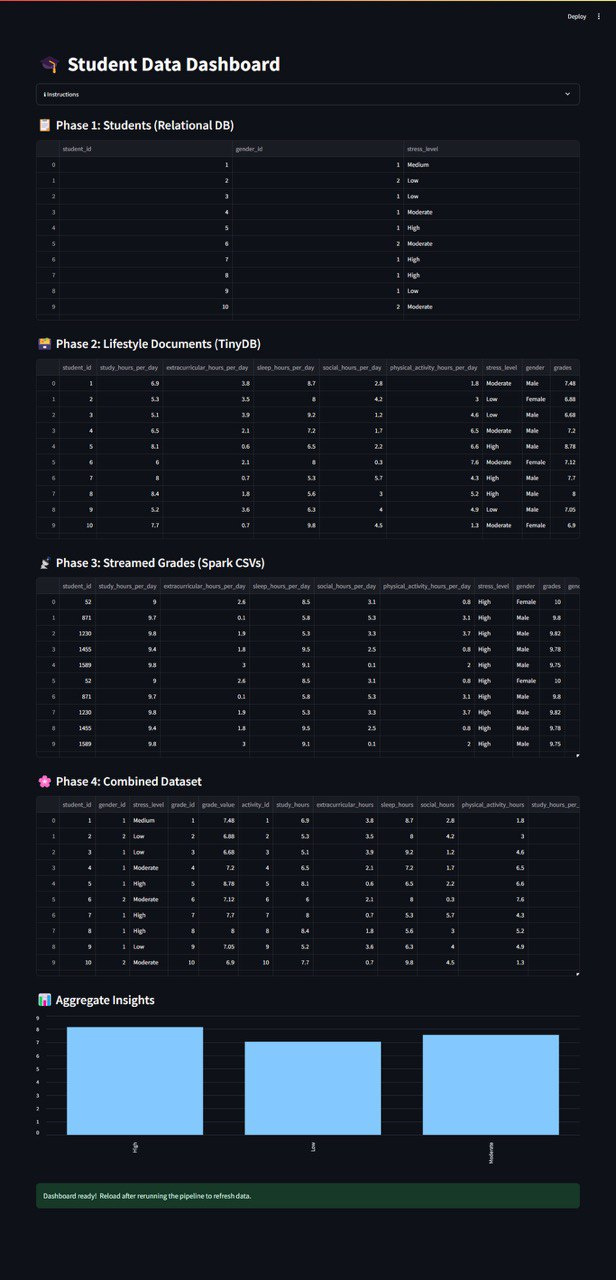